In [2]:
!nvidia-smi # Check whether your system has a GPU

Wed Dec  7 08:10:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 165...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P5     8W /  N/A |    297MiB /  3911MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import packages

In [3]:
import numpy as np
import cv2
import torch 
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

/home/densen/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


numpy 
- A scientific computing library
- Supports array operations and manipulations
- Built-in functions like array sum, diff, mean, average, min, max etc.

cv2
- To read and write images
- To perform basic vision algorithms like RGB to HSV, Gaussian Blur, Dilation, Histogram, Shape detection etc.

torch
- The open source ML framework for deep learning
- Has a pythonic interface

torchvision
- consists of popular datasets, model architectures, and common image transformations for computer vision
- Contains built in data augmentations

matplotlib
- It is a data visualization library for python
- It supports graphical plotting and viewing images and other data

nn
- The base module with which we can create and train neural nets
- Provides built-in classes for common neural network layers like Conv, Pooling, Activations, Normalizations, Dropout etc.

optim
- It is a package for implementing various optimization algorithms for model training
- Built-in optimizers like SGD, Adam, Adagrad, RMSprop etc.

# Preprocess inputs

In [4]:
transform = transforms.Compose([transforms.ToTensor()]) # Define the set of transformations to be applied on the input data

In [5]:
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])

ToTensor()
 - converts the image with a pixel range of [0, 255] to a PyTorch FloatTensor of shape (C, H, W) with a range [0.0, 1.0]

Normalize() 
- output[channel] = (input[channel] - mean[channel]) / std[channel]

- Normalization helps get data within a range and reduces the skewness which helps learn faster and better. 
- Normalization can also tackle the diminishing and exploding gradients problems.

# Create Dataloaders

- Combines a dataset and a sampler
- Provides an iterable over the given dataset
- Supports single- or multi-process loading
- Customizing loading order
- Automatic batching

In [6]:
trainset = datasets.MNIST('trainset', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

100%|██████████| 9912422/9912422 [00:05<00:00, 1856457.84it/s]


Extracting trainset/MNIST/raw/train-images-idx3-ubyte.gz to trainset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101389.99it/s]


Extracting trainset/MNIST/raw/train-labels-idx1-ubyte.gz to trainset/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1237245.87it/s]


Extracting trainset/MNIST/raw/t10k-images-idx3-ubyte.gz to trainset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5565448.08it/s]


Extracting trainset/MNIST/raw/t10k-labels-idx1-ubyte.gz to trainset/MNIST/raw



In [7]:
valset = datasets.MNIST('testset', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=8, shuffle=True)

100%|██████████| 9912422/9912422 [00:15<00:00, 633168.27it/s] 


Extracting testset/MNIST/raw/train-images-idx3-ubyte.gz to testset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1260963.23it/s]


Extracting testset/MNIST/raw/train-labels-idx1-ubyte.gz to testset/MNIST/raw



100%|██████████| 1648877/1648877 [00:03<00:00, 521240.46it/s]


Extracting testset/MNIST/raw/t10k-images-idx3-ubyte.gz to testset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 29040440.20it/s]


Extracting testset/MNIST/raw/t10k-labels-idx1-ubyte.gz to testset/MNIST/raw



In [8]:
dataiter = iter(trainloader)

Now that we have an iterator, let's visualize our data

In [9]:
images, gt_labels = dataiter.next() # The first minibatch of data

In [10]:
print(images.shape)
print(gt_labels.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8])


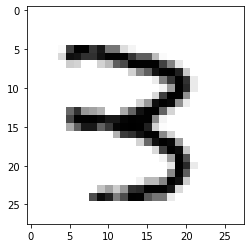

In [11]:
 # Visualize an image sample
plt.imshow(images[2].numpy().squeeze(), cmap='gray_r')

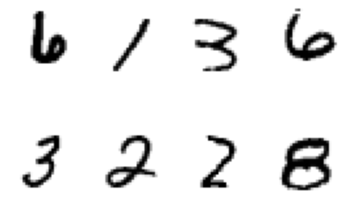

In [12]:
# Visualize all images in the minibatch
figure = plt.figure()
total_samples = 8
for index in range(1,total_samples+1):
    plt.subplot(2, 4, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

In [13]:
# Visualize the Ground truth labels
print(gt_labels)

tensor([6, 1, 3, 6, 3, 2, 2, 8])


In [14]:
# Visualize the onehot encoding of the labels
onehot_labels = nn.functional.one_hot(gt_labels, num_classes=10)
print(onehot_labels)

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])


# Let's build our DNN

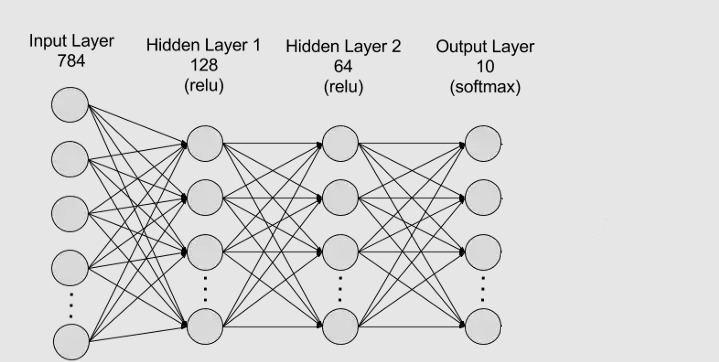

In [15]:
def create_model():
  input_size = 784
  hidden_sizes = [128, 64]
  output_size = 10

  model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[1], output_size),
                        nn.Softmax(dim=1))
  return model

In [16]:
model = create_model()

In [17]:
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


Model Weight Array

In [18]:
print(model[0].weight.shape) # Layer 1
print(model[2].weight.shape) # Layer 2
print(model[4].weight.shape) # Layer 3

torch.Size([128, 784])
torch.Size([64, 128])
torch.Size([10, 64])


In [19]:
print(model[0].weight.sum())
print(model[0].weight.mean())
print(model[0].weight.std())

tensor(-4.0035, grad_fn=<SumBackward0>)
tensor(-3.9895e-05, grad_fn=<MeanBackward0>)
tensor(0.0206, grad_fn=<StdBackward0>)


In [20]:
model[0].weight # weights of input layer

Parameter containing:
tensor([[-0.0071, -0.0080,  0.0015,  ..., -0.0069, -0.0296, -0.0118],
        [-0.0191, -0.0066, -0.0242,  ..., -0.0165,  0.0228, -0.0234],
        [-0.0243,  0.0160, -0.0099,  ..., -0.0026,  0.0107,  0.0037],
        ...,
        [ 0.0255,  0.0174, -0.0160,  ...,  0.0002,  0.0095, -0.0249],
        [ 0.0014, -0.0045, -0.0196,  ..., -0.0088, -0.0250,  0.0068],
        [-0.0272,  0.0054,  0.0084,  ..., -0.0020, -0.0213, -0.0354]],
       requires_grad=True)

# Untrained Inference

- At this point we have initialized our model with some random weights
- Lets see what the model predicts on some sample data

Lets flatten the images to a 1D array/tensor so that we can feed it to the model

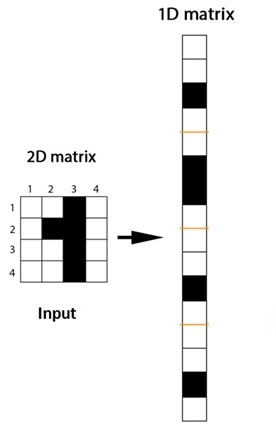

In [21]:
model_inputs = images.view(images.shape[0], -1)
model_inputs.shape

torch.Size([8, 784])

In [22]:
# The model predicts the probability of each class for each input
pred_probs = model(model_inputs)
print(pred_probs.shape)

torch.Size([8, 10])


In [23]:
# print the probability values
print(pred_probs)

tensor([[0.0980, 0.0976, 0.0949, 0.0993, 0.1108, 0.1085, 0.0900, 0.1064, 0.0948,
         0.0998],
        [0.1071, 0.1030, 0.0894, 0.0960, 0.1158, 0.1015, 0.0898, 0.1073, 0.0886,
         0.1015],
        [0.1029, 0.0992, 0.0919, 0.0983, 0.1168, 0.1081, 0.0869, 0.1072, 0.0896,
         0.0990],
        [0.1011, 0.0981, 0.0919, 0.1012, 0.1133, 0.1057, 0.0880, 0.1093, 0.0927,
         0.0988],
        [0.1018, 0.1002, 0.0936, 0.0958, 0.1137, 0.1068, 0.0899, 0.1058, 0.0914,
         0.1010],
        [0.1006, 0.0981, 0.0943, 0.1003, 0.1117, 0.1070, 0.0895, 0.1050, 0.0888,
         0.1047],
        [0.1049, 0.0992, 0.0920, 0.0937, 0.1160, 0.1049, 0.0901, 0.1094, 0.0892,
         0.1006],
        [0.1054, 0.1027, 0.0916, 0.0950, 0.1125, 0.1089, 0.0903, 0.1059, 0.0915,
         0.0961]], grad_fn=<SoftmaxBackward0>)


In [24]:
# confirm that the probability values sums to 1
print(pred_probs.sum(dim=-1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


Visualize the probabilities of a sample image

<BarContainer object of 10 artists>

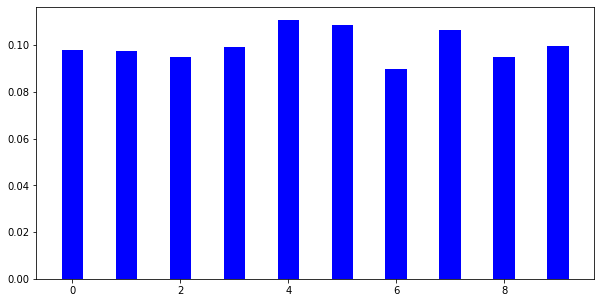

In [25]:
# set width of bar
barWidth = 0.25
fig = plt.figure(figsize = (10, 5))
x = np.arange(0,10)
y = pred_probs.detach().numpy()[0] # probability values of sample image 0
plt.bar(x, y, color ='blue',width = 0.4)

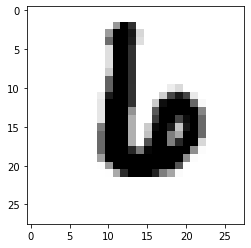

In [26]:
# see a sample image
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [27]:
# print the ground truth label
print(gt_labels[0])

tensor(6)


In [28]:
# print the ground truth onehot representation
print(onehot_labels[0])

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])


In [29]:
# print the predicted probabilities for the sample image
print(pred_probs[0])

tensor([0.0980, 0.0976, 0.0949, 0.0993, 0.1108, 0.1085, 0.0900, 0.1064, 0.0948,
        0.0998], grad_fn=<SelectBackward0>)


In [30]:
# print the predicted class number for the sample image
print(torch.argmax(pred_probs[0], dim=-1))

tensor(4)


In [31]:
# print the ground truth labels of the minibatch
print(gt_labels)

tensor([6, 1, 3, 6, 3, 2, 2, 8])


In [32]:
# print the predicted labels of the minibatch
print(torch.argmax(pred_probs, dim=-1))

tensor([4, 4, 4, 4, 4, 4, 4, 4])


The predictions are probably wrong ! The model is not trained yet. Lets see by what factor our predictions are off.

In [33]:
criterion = nn.CrossEntropyLoss()
loss = criterion(pred_probs, gt_labels)

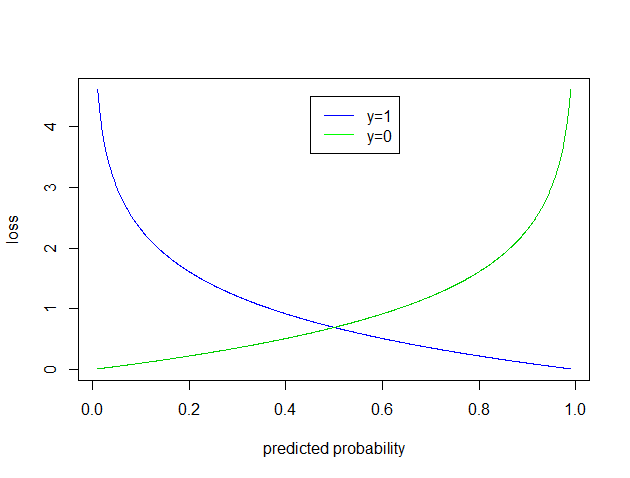

In [34]:
print(loss)

tensor(2.3085, grad_fn=<NllLossBackward0>)


# Lets do backpropogation

Model weights before backpropogation

In [35]:
print(f"sum of model weights : {model[2].weight.sum()}")
print(f"mean of model weights : {model[2].weight.mean()}")
print(f"standard deviation of model weights : {model[2].weight.std()}")
print("Weights of input layer : ")
print(model[2].weight)

sum of model weights : -0.38408994674682617
mean of model weights : -4.688597982749343e-05
standard deviation of model weights : 0.05093517526984215
Weights of input layer : 
Parameter containing:
tensor([[ 0.0074, -0.0359, -0.0294,  ...,  0.0368,  0.0501, -0.0369],
        [ 0.0633, -0.0688, -0.0168,  ..., -0.0313, -0.0422,  0.0389],
        [ 0.0748,  0.0366, -0.0127,  ..., -0.0177,  0.0641,  0.0380],
        ...,
        [-0.0531,  0.0266, -0.0005,  ...,  0.0381,  0.0323, -0.0625],
        [ 0.0062, -0.0726,  0.0037,  ...,  0.0451, -0.0270,  0.0084],
        [ 0.0191, -0.0751,  0.0604,  ...,  0.0628, -0.0228, -0.0241]],
       requires_grad=True)


Gradients of the input layer before backpropogation

In [36]:
print(model[2].weight.grad)

None


Initialize the optimizer

In [37]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

Calculate the gradients

In [38]:
loss.backward()

In [39]:
print(model[2].weight.grad)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -2.2582e-04,  0.0000e+00,  ..., -8.8888e-04,
         -8.2500e-04,  0.0000e+00],
        [ 0.0000e+00, -7.9508e-05,  0.0000e+00,  ..., -3.7187e-04,
         -2.2437e-04,  0.0000e+00],
        ...,
        [ 0.0000e+00,  3.1735e-04, -4.9721e-05,  ...,  4.4994e-04,
          7.1997e-04,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  8.4094e-06,
          2.2674e-05,  0.0000e+00],
        [ 0.0000e+00,  2.2876e-05, -6.3633e-05,  ..., -7.4442e-05,
         -3.5040e-04,  0.0000e+00]])


Check if the model weights are changed

In [40]:
print(f"sum of model weights : {model[2].weight.sum()}")
print(f"mean of model weights : {model[2].weight.mean()}")
print(f"standard deviation of model weights : {model[2].weight.std()}")
print("Weights of input layer : ")
print(model[2].weight)
# The model weights are unchanged as we have only calculated the gradients
# Now, lets update the weights based on the gradients

sum of model weights : -0.38408994674682617
mean of model weights : -4.688597982749343e-05
standard deviation of model weights : 0.05093517526984215
Weights of input layer : 
Parameter containing:
tensor([[ 0.0074, -0.0359, -0.0294,  ...,  0.0368,  0.0501, -0.0369],
        [ 0.0633, -0.0688, -0.0168,  ..., -0.0313, -0.0422,  0.0389],
        [ 0.0748,  0.0366, -0.0127,  ..., -0.0177,  0.0641,  0.0380],
        ...,
        [-0.0531,  0.0266, -0.0005,  ...,  0.0381,  0.0323, -0.0625],
        [ 0.0062, -0.0726,  0.0037,  ...,  0.0451, -0.0270,  0.0084],
        [ 0.0191, -0.0751,  0.0604,  ...,  0.0628, -0.0228, -0.0241]],
       requires_grad=True)


Run the optimizer

In [41]:
optimizer.step()

Lets check if the weights are updated

In [42]:
print(f"sum of model weights : {model[2].weight.sum()}")
print(f"mean of model weights : {model[2].weight.mean()}")
print(f"standard deviation of model weights : {model[2].weight.std()}")
print("Weights of input layer : ")
print(model[2].weight)
# Although infinitesimally small, the weights are changed

sum of model weights : -0.38382673263549805
mean of model weights : -4.6853849198669195e-05
standard deviation of model weights : 0.050935178995132446
Weights of input layer : 
Parameter containing:
tensor([[ 0.0074, -0.0359, -0.0294,  ...,  0.0368,  0.0501, -0.0369],
        [ 0.0633, -0.0687, -0.0168,  ..., -0.0313, -0.0422,  0.0389],
        [ 0.0748,  0.0366, -0.0127,  ..., -0.0177,  0.0641,  0.0380],
        ...,
        [-0.0531,  0.0266, -0.0005,  ...,  0.0381,  0.0323, -0.0625],
        [ 0.0062, -0.0726,  0.0037,  ...,  0.0451, -0.0270,  0.0084],
        [ 0.0191, -0.0751,  0.0604,  ...,  0.0628, -0.0228, -0.0241]],
       requires_grad=True)


# Model Training

Initialize the optimizer, total epochs etc.

In [43]:
model = create_model()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 2

In [44]:
time_init = time() # record the time at which training started

for e in range(epochs):
    running_loss = 0
    for images, gt_labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad() # reset the gradients of model weights
        
        output = model(images)
        loss = criterion(output, gt_labels)
        
        # Calculate the gradients of the learnable parameters
        loss.backward()
        
        # Modify the model weights as per the gradients
        optimizer.step()
        
        running_loss += loss.item()

    average_loss = running_loss/len(trainloader)
    print(f"Epoch {e} - Training loss: {average_loss}\n")
print(f"Training Time (in minutes) = {(time()-time_init)/60}")

Epoch 0 - Training loss: 1.8627126430988312

Epoch 1 - Training loss: 1.637863937075933

Training Time (in minutes) = 0.367769988377889


# Model Validation

In [45]:
images, gt_labels = next(iter(valloader))

with torch.no_grad():
    pred_probs = model(images.view(images.shape[0], -1))

predicted_labels = torch.argmax(pred_probs, dim=-1)

Lets visualize the validation input images

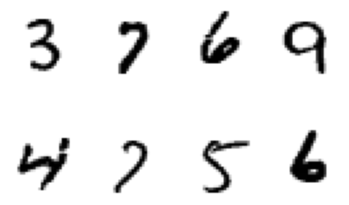

In [46]:
# Visualize all images in the minibatch
figure = plt.figure()
total_samples = 8
for index in range(1,total_samples+1):
    plt.subplot(2, 4, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

Ground truth class labels

In [47]:
print(f"Ground truth labels : {gt_labels}")

Ground truth labels : tensor([3, 7, 6, 9, 4, 7, 5, 6])


Predicted class labels

In [48]:
print(f"Predicted labels : {predicted_labels}",)

Predicted labels : tensor([3, 7, 6, 4, 4, 7, 5, 6])


Calculate the accuracy for the minibatch of validation data

In [49]:
correct_count = 0
total_count = 0
for i in range(len(gt_labels)):
  img = images[i].view(1, 784)
  if predicted_labels[i]==gt_labels[i]:
    correct_count = correct_count+1
  total_count = total_count+1
accuracy = correct_count/total_count
print(f"The accuracy on the minibatch is : {accuracy}")

The accuracy on the minibatch is : 0.875


Lets go through all the validation images and calculate the overall accuracy

In [50]:
correct_count = 0
total_count = 0

for images,gt_labels in valloader:
  pred_probs = model(images.view(images.shape[0], -1))
  predicted_labels = torch.argmax(pred_probs, dim=-1)

  for i in range(len(gt_labels)):
    if predicted_labels[i]==gt_labels[i]:
      correct_count = correct_count+1
    total_count = total_count+1       

accuracy = correct_count/total_count
print(f"Number of validation images = {total_count}\n")
print(f"Model Accuracy = {accuracy}")

Number of validation images = 10000

Model Accuracy = 0.8373


In [51]:
torch.save(model, './first_mnist_model.pt') 

# Better Training Loops

- Add a progress bar for the training
- After each epoch, validate the model to see if the model has converged or whether it is overfit


In [52]:
model = create_model()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 2
pbar = tqdm(range(epochs))
best_accuracy = 0.0

  0%|          | 0/8 [00:00<?, ?it/s]

In [53]:
time_init = time() # record the time at which training started

for e in pbar:
    running_loss = 0
    for images, gt_labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad() # reset the gradients of model weights
        
        output = model(images)
        loss = criterion(output, gt_labels)
        
        # Calculate the gradients of the learnable parameters
        loss.backward()
        
        # Modify the model weights as per the gradients
        optimizer.step()
        
        running_loss += loss.item()
    average_loss = running_loss/len(trainloader)
    
    # perform validation
    correct_count = 0
    total_count = 0
    for images,gt_labels in valloader:
      pred_probs = model(images.view(images.shape[0], -1))
      predicted_labels = torch.argmax(pred_probs, dim=-1)

      for i in range(len(gt_labels)):
        if predicted_labels[i]==gt_labels[i]:
          correct_count = correct_count+1
        total_count = total_count+1       

    accuracy = correct_count/total_count
    
    # save the model weights
    if accuracy>=best_accuracy:
      best_accuracy = accuracy
      torch.save(model, './best_mnist_model.pt')
    torch.save(model, './best_mnist_model.pt') 

    print(f"\nEpoch {e} - Training loss: {average_loss}, val accuracy : {accuracy}")
print(f"Training Time (in minutes) = {(time()-time_init)/60}")

 12%|█▎        | 1/8 [00:12<01:25, 12.23s/it]


Epoch 0 - Training loss: 1.8248036059220631, val accuracy : 0.8424


 25%|██▌       | 2/8 [00:24<01:13, 12.27s/it]


Epoch 1 - Training loss: 1.6199820726235707, val accuracy : 0.8557


 38%|███▊      | 3/8 [00:37<01:03, 12.77s/it]


Epoch 2 - Training loss: 1.607364007806778, val accuracy : 0.863


# Visualize the training progress

Lets visualize the trend of loss and accuracies over the course of the model training

In [ ]:
# only for Google colab
%load_ext tensorboard
%tensorboard --logdir=runs --load_fast=false

In [ ]:
from torch.utils.tensorboard import SummaryWriter
summary_writer = SummaryWriter()

In [ ]:
model = create_model()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 100
pbar = tqdm(range(epochs))
best_accuracy = 0.0

In [ ]:
time_init = time() # record the time at which training started

for e in pbar:
    running_loss = 0
    for images, gt_labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        images = images.cuda()
        gt_labels = gt_labels.cuda()
    
        # Training pass
        optimizer.zero_grad() # reset the gradients of model weights
        
        output = model(images)
        loss = criterion(output, gt_labels)
        
        # Calculate the gradients of the learnable parameters
        loss.backward()
        
        # Modify the model weights as per the gradients
        optimizer.step()
        
        running_loss += loss.item()
    average_loss = running_loss/len(trainloader)
    
    # perform validation
    correct_count = 0
    total_count = 0
    for images,gt_labels in valloader:
      images = images.cuda()
      gt_labels = gt_labels.cuda()
      pred_probs = model(images.view(images.shape[0], -1))
      predicted_labels = torch.argmax(pred_probs, dim=-1)

      for i in range(len(gt_labels)):
        if predicted_labels[i]==gt_labels[i]:
          correct_count = correct_count+1
        total_count = total_count+1       

    accuracy = correct_count/total_count

    # save the model weights
    if accuracy>=best_accuracy:
      best_accuracy = accuracy
      torch.save(model, './best_mnist_model.pt')
    torch.save(model, './best_mnist_model.pt') 

    print(f"\nEpoch {e} - Training loss: {average_loss}, val accuracy : {accuracy}")
    summary_writer.add_scalar("train_loss", average_loss, e)
    summary_writer.add_scalar("val_accuracy", accuracy, e)
print(f"Training Time (in minutes) = {(time()-time_init)/60}")
summary_writer.flush()
summary_writer.close()

In [ ]:
# time_init = time() # record the time at which training started

# for e in pbar:
#     running_loss = 0
#     for images, gt_labels in trainloader:
#         # Flatten MNIST images into a 784 long vector
#         images = images.view(images.shape[0], -1)
    
#         # Training pass
#         optimizer.zero_grad() # reset the gradients of model weights
        
#         output = model(images)
#         loss = criterion(output, gt_labels)
        
#         # Calculate the gradients of the learnable parameters
#         loss.backward()
        
#         # Modify the model weights as per the gradients
#         optimizer.step()
        
#         running_loss += loss.item()
#     average_loss = running_loss/len(trainloader)
    
#     # perform validation
#     correct_count = 0
#     total_count = 0
#     for images,gt_labels in valloader:
#       pred_probs = model(images.view(images.shape[0], -1))
#       predicted_labels = torch.argmax(pred_probs, dim=-1)

#       for i in range(len(gt_labels)):
#         if predicted_labels[i]==gt_labels[i]:
#           correct_count = correct_count+1
#         total_count = total_count+1       

#     accuracy = correct_count/total_count

#     # save the model weights
#     if accuracy>=best_accuracy:
#       best_accuracy = accuracy
#       torch.save(model, './best_mnist_model.pt')
#     torch.save(model, './best_mnist_model.pt') 

#     print(f"\nEpoch {e} - Training loss: {average_loss}, val accuracy : {accuracy}")
#     summary_writer.add_scalar("train_loss", average_loss, e)
#     summary_writer.add_scalar("val_accuracy", accuracy, e)
# print(f"Training Time (in minutes) = {(time()-time_init)/60}")
# summary_writer.flush()
# summary_writer.close()